# TP N°2 - Predicción de Enfermedades Cardíacas mediante Ensambles

Primero importamos las librerias que vamos a utilizar con sus versiones correspondientes

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

print("Numpy version : ", np.__version__)
print("Pandas version : ", pd.__version__)
print("Sklearn version : ", sk.__version__)

Numpy version :  1.16.4
Pandas version :  0.24.2
Sklearn version :  0.21.2


Ejecutar esta notebook con las siguientes versiones de Numpy, Pandas y Sklearn:
<ul>
<li>Numpy version :  1.16.4</li>
<li>Pandas version :  0.24.2</li>
<li>Sklearn version :  0.21.2</li>
</ul>

<font color=red>**ATENCIÓN: UTILIZAR SKLEARN V0.21.2 QUE SOPORTA EL USO DE ITERATIVE IMPUTER, VERSIONES ANTERIORES NO LO IMPLEMENTAN.**</font>

## Carga y Visualización del DataSet

Guardamos el CSV que contiene el dataset crudo en un DataFrame de Pandas, el cual procesaremos para ajustarlo a los objetivos del trabajo. 

In [2]:
# Cargo el data set a partir del CSV
dataset = pd.read_csv("Heart_Disease_Data.csv", delimiter=',', na_values="?", low_memory = False)

dataset.shape # Cantidad de registros y atributos

(920, 14)

La columna <i>pred_attribute</i> es el atributo de clase, que contiene 5 valores posibles. Valores del 1 al 4 representan existencia de una enfermedad cardíaca. Estamos interesados únicamente en detectar presencia o ausencia de enfermedad, con lo cual binarizo esta variable: 0 no tiene enfermedad cardíaca, 1 tiene enfermedad cardíaca

In [3]:
dataset["pred_attribute"].replace(inplace=True, value=[1, 1, 1, 1], to_replace=[1, 2, 3, 4])
dataset.dtypes

age                 int64
sex                 int64
cp                  int64
trestbps          float64
chol              float64
fbs               float64
restecg           float64
thalach           float64
exang             float64
oldpeak           float64
slop              float64
ca                float64
thal              float64
pred_attribute      int64
dtype: object

In [4]:
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slop,ca,thal,pred_attribute
0,63,1,1,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67,1,4,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67,1,4,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37,1,3,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41,0,2,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [5]:
print("Porcentaje de enfermedades cardíacas en el dataset: {:.2%}".format(dataset[dataset['pred_attribute'] == 1].shape[0] / dataset.shape[0]))

Porcentaje de enfermedades cardíacas en el dataset: 55.33%


Calculamos la correlación de todas las variables numéricas (y booleanas) contra la salida: 

In [6]:
corr = dataset.corrwith(dataset.pred_attribute, drop=True)
corr

age               0.282700
sex               0.307284
cp                0.471712
trestbps          0.106233
chol             -0.230583
fbs               0.142565
restecg           0.063867
thalach          -0.394503
exang             0.463619
oldpeak           0.385528
slop              0.337086
ca                0.455599
thal              0.498521
pred_attribute    1.000000
dtype: float64

La variable *restecg* tiene baja correlación con la clase que quiero predecir.

## Imputación de valores faltantes

Verifiquemos la existencia de datos faltantes:

In [7]:
dataset.isnull().sum()

age                 0
sex                 0
cp                  0
trestbps           59
chol               30
fbs                90
restecg             2
thalach            55
exang              55
oldpeak            62
slop              309
ca                611
thal              486
pred_attribute      0
dtype: int64

La mayoría de los atributos contiene valores faltantes, sobre todo <i>slop</i>, <i>ca</i> y <i>thal</i>. Vamos a utilizar una técnica de imputación múltiple, que modela a cada variable con valor faltante como una función del resto de las variables, y usa como imputación el valor estimado a partir de dicha función. Lo hace en forma iterativa: en cada paso, se designa una columna como variable de salida <i>y</i> y el resto como entradas <i>X</i>. Se calcula una regresión en (X, y), para <i>y</i> conocido y se utiliza esa regresión para predecir los valores faltantes de <i>y</i>. Se hace esto para cada feature con valores faltantes de forma iterativa y se repite un máximo de veces especificado (1000 veces en este caso).

In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

X_df = dataset.iloc[:, :-1] 
y_df = dataset.iloc[:, -1]

imputer = IterativeImputer(max_iter=1000, random_state=0)
t_values = imputer.fit_transform(X_df.values)
X_df = pd.DataFrame(t_values, columns=X_df.columns)

dataset_imp = pd.concat([X_df, pd.DataFrame(y_df)], sort=False, axis=1)

dataset_imp.loc[np.isnan(dataset.fbs), "fbs"] = np.round(dataset_imp.loc[np.isnan(dataset.fbs), "fbs"])
dataset_imp.loc[np.isnan(dataset.restecg), "restecg"] = np.round(dataset_imp.loc[np.isnan(dataset.restecg), "restecg"])
dataset_imp.loc[np.isnan(dataset.exang), "exang"] = np.round(dataset_imp.loc[np.isnan(dataset.exang), "exang"])
dataset_imp.loc[np.isnan(dataset.slop), "slop"] = np.round(dataset_imp.loc[np.isnan(dataset.slop), "slop"])
dataset_imp.loc[np.isnan(dataset.ca), "ca"] = np.round(dataset_imp.loc[np.isnan(dataset.ca), "ca"])

index = dataset_imp.loc[np.isnan(dataset.thal), "thal"] < 5.2
dataset_imp.loc[index.loc[index].index, "thal"] = 3.0

index = (dataset_imp.loc[np.isnan(dataset.thal), "thal"] >= 5.2) & (dataset_imp.loc[np.isnan(dataset.thal), "thal"] < 6.00001)
dataset_imp.loc[index.loc[index].index, "thal"] = 6.0

index = dataset_imp.loc[np.isnan(dataset.thal), "thal"] >= 6.00001
dataset_imp.loc[index.loc[index].index, "thal"] = 7.0

X_df = dataset_imp.iloc[:, :-1] 
y_df = dataset_imp.iloc[:, -1]

## Visualización de datos

Primero grafiquemos los histogramas y graficos de dispersión de los atributos continuos:

In [9]:
# 13 dataset features
feature13 = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slop','ca','thal']
features_continuous = ["age", "trestbps", "chol", "thalach", "oldpeak"] # Valores continuos

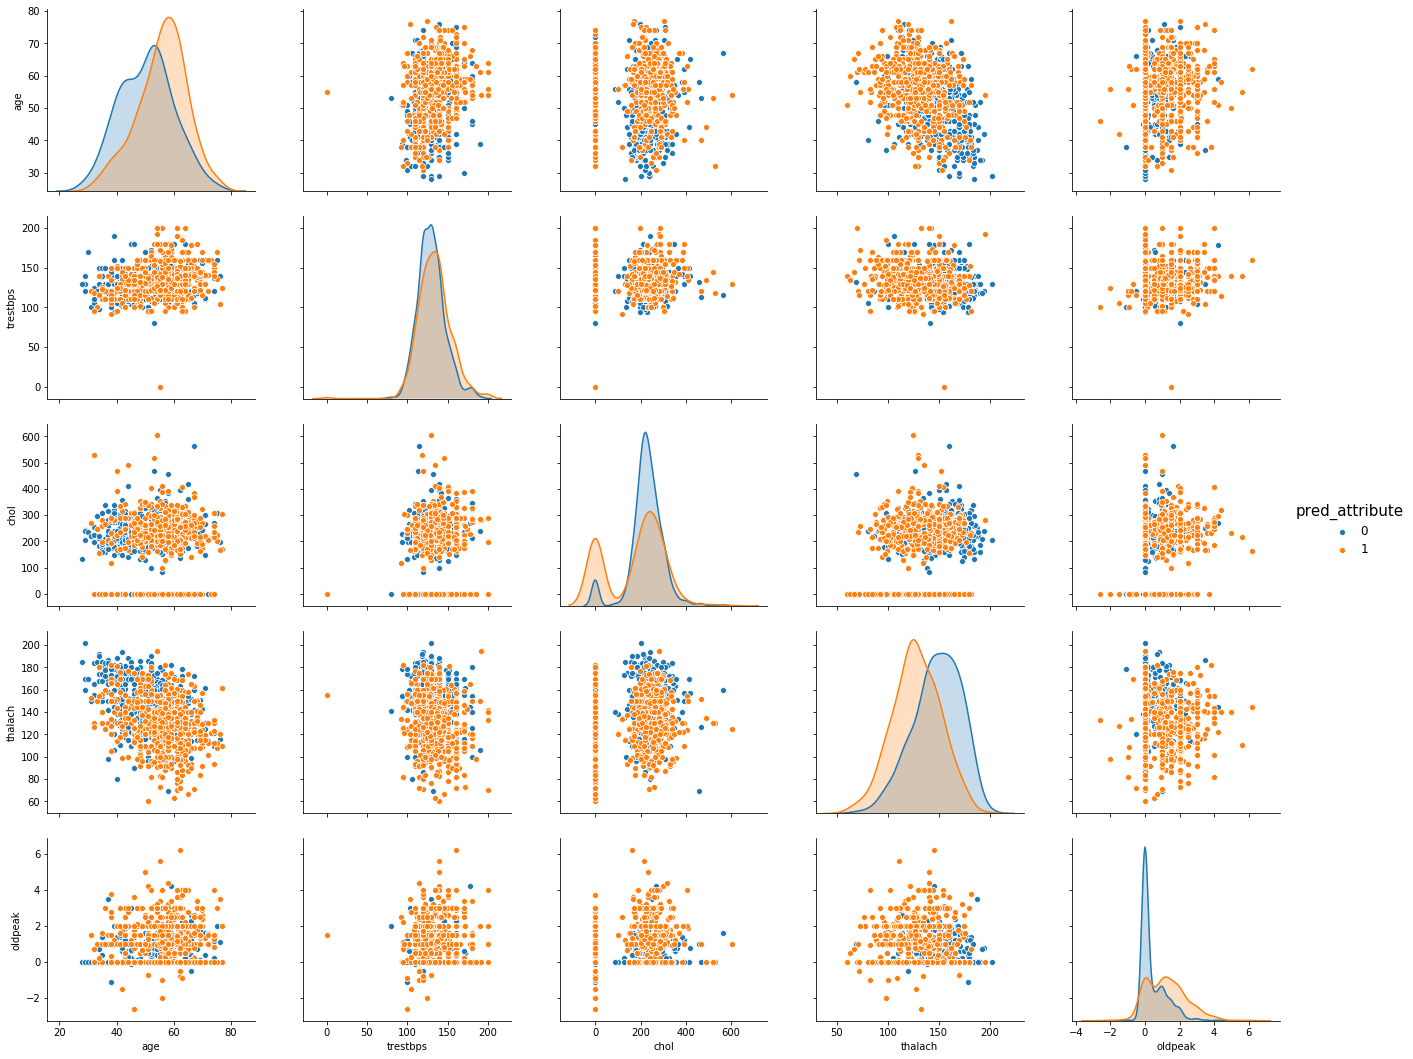

In [10]:
ax = sns.pairplot(dataset_imp, vars=features_continuous, hue="pred_attribute", diag_kind='kde')
plt.setp(ax._legend.get_title(), fontsize=15)
plt.setp(ax._legend.get_texts(), fontsize=12)
plt.gcf().set_size_inches(20,15)
plt.show()

Los gráficos de la diagonal muestran los histogramas de cada variable continua separados por clase (presencia o ausencia de enfermedad). Los gráficos de dispersión muestran la relación entre cada uno de los atributos o features tomados de a dos. Se observa que no hay ningún par de atributos que sea capaz (por lo menos en dos dimensiones) de separar claramente ambas clases.

A continuación graficamos los box plots de las variables continuas, para ver su distribución.

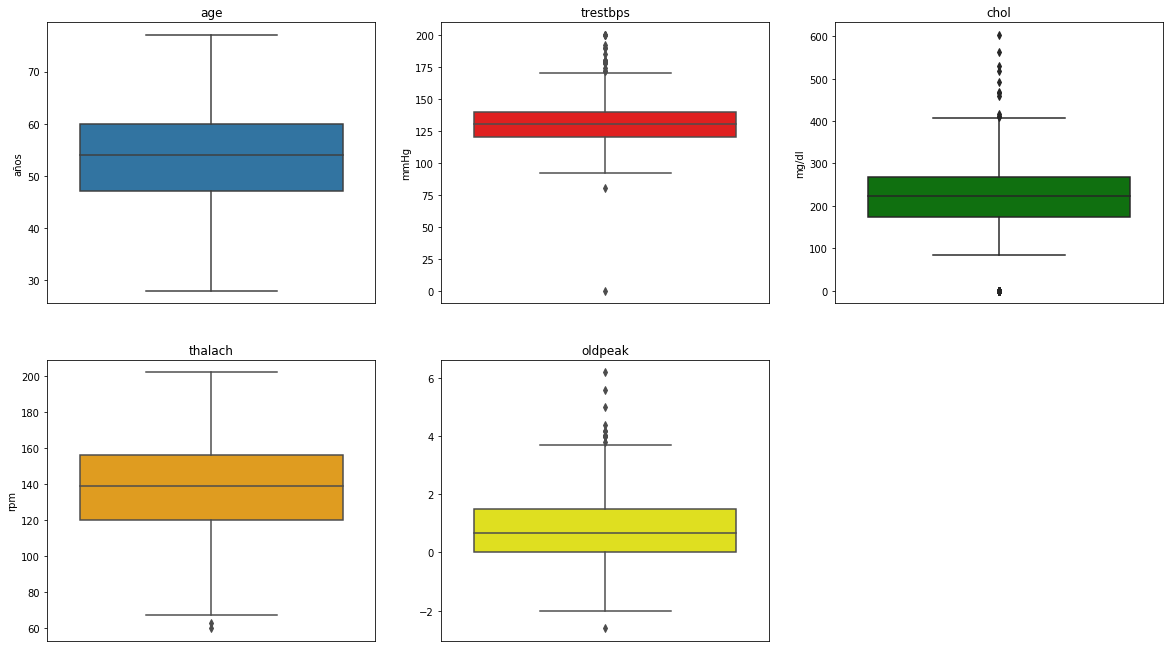

In [11]:
plt.figure(figsize=(20,30))

#plt.suptitle("Box Plots",fontsize=20)
#plt.subplots_adjust(wspace = 0.2, hspace= 0.2)

ax1 = plt.subplot(5,3,1)
ax1.set_ylabel("años")
ax1.tick_params(
    axis='x',
    bottom=False,
    labelbottom=False)
plt.title("age")
sns.boxplot(data=dataset_imp["age"])

ax2 = plt.subplot(5,3,2)
ax2.set_ylabel("mmHg")
ax2.tick_params(
    axis='x',
    bottom=False,
    labelbottom=False)
plt.title("trestbps")
sns.boxplot(data=dataset_imp["trestbps"], color="red")

ax3 = plt.subplot(5,3,3)
ax3.set_ylabel("mg/dl")
ax3.tick_params(
    axis='x',
    bottom=False,
    labelbottom=False)
plt.title("chol")
sns.boxplot(data=dataset_imp["chol"], color="green")

ax4 = plt.subplot(5,3,4)
ax4.set_ylabel("rpm")
ax4.tick_params(
    axis='x',
    bottom=False,
    labelbottom=False)
plt.title("thalach")
sns.boxplot(data=dataset_imp["thalach"], color="orange")

ax5 = plt.subplot(5,3,5)
ax5.tick_params(
    axis='x',
    bottom=False,
    labelbottom=False)
plt.title("oldpeak")
sns.boxplot(data=dataset_imp["oldpeak"], color="yellow")

plt.show()

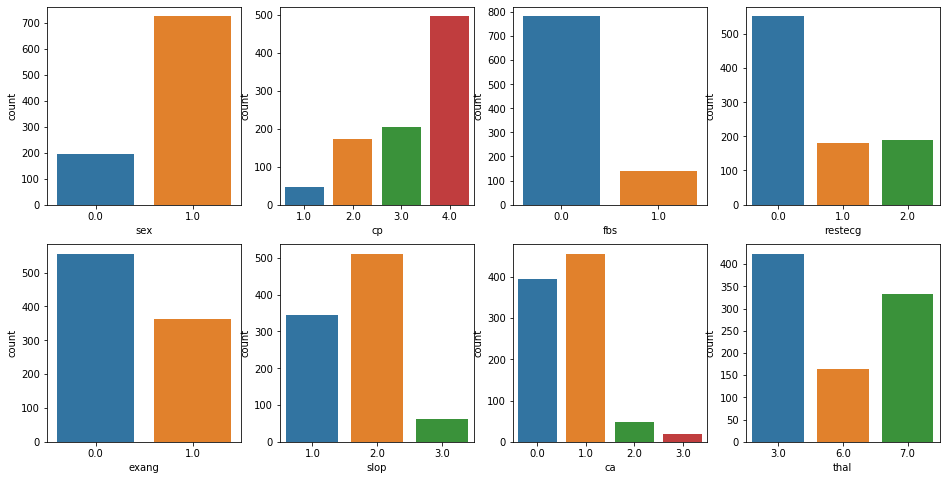

In [12]:
fig, ax = plt.subplots(2,4)
sns.countplot(x='sex', data=dataset_imp, ax=ax[0,0])
sns.countplot(x='cp', data=dataset_imp, ax=ax[0,1])
sns.countplot(x='fbs', data=dataset_imp, ax=ax[0,2])
sns.countplot(x='restecg', data=dataset_imp, ax=ax[0,3])
sns.countplot(x='exang', data=dataset_imp, ax=ax[1,0])
sns.countplot(x='slop', data=dataset_imp, ax=ax[1,1])
sns.countplot(x='ca', data=dataset_imp, ax=ax[1,2])
sns.countplot(x='thal', data=dataset_imp, ax=ax[1,3])
plt.gcf().set_size_inches(16,8)
plt.show()

## Partición de datos

Separamos al azar un 20% de los datos para usarlos como datos de test o hold-out, y el 80% restante como datos de desarrollo para seleccionar los hiperparámetros óptimos mediante 5-fold cross-validation en cada modelo utilizado:

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Utilizo train_test_split estratificado, que divido los datos de test y de desarrollo al azar pero teniendo 
# en cuenta la proporcion de datos pertenecientes a las diferentes clases
Xdev, Xtest, ydev, ytest = train_test_split(X_df, y_df, test_size=0.2, random_state=0, shuffle=True, stratify=y_df)

## Funciones a utilizar

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer

# Implemento función que calcula el score f2
def f2_score_func(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

f2_score = make_scorer(f2_score_func, greater_is_better=True)

In [15]:
# Función que muestra los 8 scores principales (Accuracy, Precision, Recall, F1, TPR, FPR, TNR y FNR)
# calculados sobre los datos de validación (promediados en los 5 folds)
def showCVScores(clf):
    acc = clf.cv_results_['mean_test_accuracy'][clf.best_index_]
    delta_acc = clf.cv_results_['std_test_accuracy'][clf.best_index_] 
    p = clf.cv_results_['mean_test_precision'][clf.best_index_]
    delta_p = clf.cv_results_['std_test_precision'][clf.best_index_] 
    r = clf.cv_results_['mean_test_recall'][clf.best_index_]
    delta_r = clf.cv_results_['std_test_recall'][clf.best_index_]
    f1 = clf.cv_results_['mean_test_f1'][clf.best_index_]
    delta_f1 = clf.cv_results_['std_test_f1'][clf.best_index_]
 
    # FORMULAS PARA CALCULAR tpr, fpr, fnr y tnr a partir de precision, recall y accuracy
    # Lo tengo que hacer de esta manera ya que grid-search con CV no devuelve estos scores
    tpr = p*r*(1-acc)/(p+r-2*p*r)
    fpr = r*(1-p)*(1-acc)/(p+r-2*p*r)
    fnr = p*(1-r)*(1-acc)/(p+r-2*p*r)
    tnr = 1 - (tpr+fpr+fnr)

    print('Accuracy promedio: {:.2%} +/- {:.2%}'.format(acc, delta_acc))
    print('Precision promedio: {:.2%} +/- {:.2%}'.format(p, delta_p))
    print('Recall promedio: {:.2%} +/- {:.2%}'.format(r, delta_r))
    print('F1 promedio: {:.2%} +/- {:.2%}'.format(f1, delta_f1))
    
    print('TP Rate promedio: {:.2%}'.format(tpr))
    print('FP Rate promedio: {:.2%}'.format(fpr))
    print('TN Rate promedio: {:.2%}'.format(tnr))
    print('FN Rate promedio: {:.2%}'.format(fnr))


# Función que muestra los 8 scores principales (Accuracy, Precision, Recall, F1, TPR, FPR, TNR y FNR)
# dados el vector de predicciones y el vector de valores reales
def showTestScores(ytest, ypred):
    acc = accuracy_score(ytest, ypred)
    p = precision_score(ytest, ypred)
    r = recall_score(ytest, ypred)
    f1 = f1_score(ytest, ypred)
    
    tpr = np.sum((ytest == 1) & (ypred == 1)) / ytest.shape[0]
    fpr = np.sum((ytest == 0) & (ypred == 1)) / ytest.shape[0]
    fnr = np.sum((ytest == 1) & (ypred == 0)) / ytest.shape[0]
    tnr = np.sum((ytest == 0) & (ypred == 0)) / ytest.shape[0]

    print('Accuracy: {:.2%}'.format(acc))
    print('Precision: {:.2%}'.format(p))
    print('Recall: {:.2%}'.format(r))
    print('F1: {:.2%}'.format(f1))
    
    print('TP Rate: {:.2%}'.format(tpr))
    print('FP Rate: {:.2%}'.format(fpr))
    print('TN Rate: {:.2%}'.format(tnr))
    print('FN Rate: {:.2%}'.format(fnr))


In [16]:
# Función que devuelve los importance features dados un modelo y uno data set
def get_fi(model, data):
    features = data.columns
    importances = model.feature_importances_
    fi = pd.DataFrame({'feature': features, 'importance': importances})
    return fi.sort_values(by="importance", ascending=True)

## BAGGING 

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier

# Hacemos un grid search para determinar cuales son los mejores parametros para el Bagging classifier.
# Los parametros en este caso son:
# max_samples: la proporción de muestras a tomar de X para entrenar cada estimador base
# max_features: el número de features a tomar de X para entrenar cada estimador base
# bootstrap: True si las muestras se toman con reemplazo
# bootstrap_features: True si los features se toman con reemplazo
parameters = {'max_samples':np.linspace(.1,1,19), 'max_features':range(2,14),
             'bootstrap':[True, False], 'bootstrap_features':[True, False]}

scoring = ['accuracy', 'precision', 'f1', 'recall']

clf = BaggingClassifier(random_state=0, n_estimators=200)

baggingClf = GridSearchCV(clf, parameters, n_jobs=-1, cv=5, scoring=scoring, refit='f1')

# DESCOMENTAR PARA CORRER EL GRID SEARCH Y MOSTRAR RESULTADOS DE SCORES (TARDA UNOS MINUTOS)
#baggingClf.fit(Xdev, ydev)
#showCVScores(baggingClf)

**RESULTADOS CV - BAGGING** </br>
<i>Resultado de scores promedios sobre los conjuntos de validación en cada fold:</i>

Accuracy promedio: 84.65% +/- 1.30% </br>
Precision promedio: 84.45% +/- 2.32% </br>
Recall promedio: 88.70% +/- 2.45% </br>
F1 promedio: 86.47% +/- 1.07% </br>
TP Rate promedio: 49.29% </br>
FP Rate promedio: 9.07% </br>
TN Rate promedio: 35.36% </br>
FN Rate promedio: 6.28%

**HIPERPARÁMETROS ÓPTIMOS - BAGGING:** </br>
- max_samples = 0.3
- max_features = 10
- bootstrap = False
- bootstrap_features = True

In [18]:
# MEJOR CLASIFICADOR BAGGING
baggingBestClf = BaggingClassifier(random_state=0, n_estimators=200, bootstrap_features = True, bootstrap = False,
                               max_samples = 0.3, max_features = 10)

baggingBestClf.fit(Xdev, ydev)
ypred_bagging = baggingBestClf.predict(Xtest)

showTestScores(ytest, ypred_bagging)

Accuracy: 88.04%
Precision: 86.36%
Recall: 93.14%
F1: 89.62%
TP Rate: 51.63%
FP Rate: 8.15%
TN Rate: 36.41%
FN Rate: 3.80%


## RANDOM FOREST

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Hacemos un grid search para determinar cuales son los mejores parametros para el RandomForest classifier.
# Los parametros en este caso son:
# criterion: criterio para ramificar nodos del arbol (entropía o impureza Gini)
# max_depth: altura máxima del árbol
# max_features: el número de features a tomar aleatoriamente de X para splitear en cada nodo
# bootstrap: True si las muestras se toman con reemplazo
# min_samples_split: Mínimo número de muestras para separar un nodo
# min_samples_leaf: Mínimo número de muestras requerido para ser un nodo hoja
parameters = {'criterion':['gini', 'entropy'], 'max_depth':range(2,14), 'max_features':['sqrt', 'log2', None],
             'bootstrap':[True, False], 'min_samples_split':range(2,6), 'min_samples_leaf':range(1,6)}

clf = RandomForestClassifier(random_state=0, n_estimators = 200)

randomForestClf = GridSearchCV(clf, parameters, n_jobs=-1, cv=5, scoring=scoring, refit='f1')

# DESCOMENTAR PARA CORRER EL GRID SEARCH Y MOSTRAR RESULTADOS DE SCORES (TARDA UNOS MINUTOS)
#randomForestClf.fit(Xdev, ydev)
#showCVScores(randomForestClf)

**RESULTADOS CV - RANDOM FOREST** </br>
<i>Resultado de scores promedios sobre los conjuntos de validación en cada fold:</i>

Accuracy promedio: 83.97% +/- 1.07% </br>
Precision promedio: 84.24% +/- 2.06% </br>
Recall promedio: 87.47% +/- 1.75% </br>
F1 promedio: 85.79% +/- 0.79% </br>
TP Rate promedio: 48.54% </br>
FP Rate promedio: 9.08% </br>
TN Rate promedio: 35.43% </br>
FN Rate promedio: 6.95%

**HIPERPARÁMETROS ÓPTIMOS - RANDOM FOREST:** </br>
- criterion = gini
- max_depth = 5
- max_features = 'sqrt'
- bootstrap = True
- min_samples_split = 2
- min_samples_leaf = 2

In [20]:
# MEJOR CLASIFICADOR RANDOM FOREST
RFBestClf = RandomForestClassifier(random_state=0, n_estimators=200, bootstrap = True, criterion = 'gini', 
                                   max_depth = 5, max_features = 'sqrt', min_samples_split=2, min_samples_leaf=2)

RFBestClf.fit(Xdev, ydev)
ypred_rf = RFBestClf.predict(Xtest)

showTestScores(ytest, ypred_rf)

Accuracy: 85.87%
Precision: 85.19%
Recall: 90.20%
F1: 87.62%
TP Rate: 50.00%
FP Rate: 8.70%
TN Rate: 35.87%
FN Rate: 5.43%


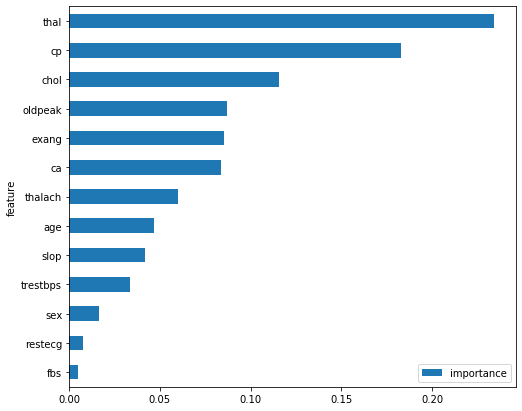

In [21]:
fi = get_fi(RFBestClf, Xdev)
fi.plot('feature', 'importance', 'barh', figsize=(8,7), legend = True)

## Clasificación via AdaBoost

In [22]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Dos posibles arboles básicos para el AdaBoost: de altura 1 o de altura 2
dt1, dt2 = (DecisionTreeClassifier(max_depth=1, random_state=0), DecisionTreeClassifier(max_depth=2, random_state=0))

# Hacemos un grid search para determinar cuales son los mejores parametros para el AdaBoost classifier.
# Los parametros en este caso son:
# base_estimator: el estimador base utilizado para el Boosting (de altura 1 o de altura 2)
# n_estimators: el número máximo de estimadores base a utilizar (cantidad de iteraciones)
# learning_rate: tasa de aprendizaje que controla la contribución de cada estimador.  
parameters = {'base_estimator':[dt1, dt2], 'n_estimators':range(50,400, 10), 'learning_rate':np.linspace(.01,.1,19)}

clf = AdaBoostClassifier(random_state=0)

adaBoostClf = GridSearchCV(clf, parameters, n_jobs=-1, cv=5, scoring=scoring, refit='f1')

# DESCOMENTAR PARA CORRER EL GRID SEARCH Y MOSTRAR RESULTADOS DE SCORES (TARDA UNOS MINUTOS)
#adaBoostClf.fit(Xdev, ydev)
#showCVScores(adaBoostClf)

**RESULTADOS CV - ADABOOST** </br>
<i>Resultado de scores promedios sobre los conjuntos de validación en cada fold:</i>

Accuracy promedio: 84.65% +/- 1.80% </br>
Precision promedio: 85.23% +/- 1.97% </br>
Recall promedio: 87.47% +/- 3.45% </br>
F1 promedio: 86.28% +/- 1.74% </br>
TP Rate promedio: 48.50% </br>
FP Rate promedio: 8.40% </br>
TN Rate promedio: 36.14% </br>
FN Rate promedio: 6.95%

**HIPERPARÁMETROS ÓPTIMOS - ADABOOST:** </br>
- base_estimator = arbol de altura 2
- n_estimators = 230
- learning_rate = 0.02

In [23]:
# MEJOR CLASIFICADOR ADA BOOST
base_est = DecisionTreeClassifier(max_depth=2, random_state=0)

adaBoostBestClf = AdaBoostClassifier(base_estimator = base_est, random_state=0, n_estimators=230, learning_rate = 0.02)

adaBoostBestClf.fit(Xdev, ydev)
ypred_adaboost = adaBoostBestClf.predict(Xtest)

showTestScores(ytest, ypred_adaboost)

Accuracy: 85.33%
Precision: 85.71%
Recall: 88.24%
F1: 86.96%
TP Rate: 48.91%
FP Rate: 8.15%
TN Rate: 36.41%
FN Rate: 6.52%


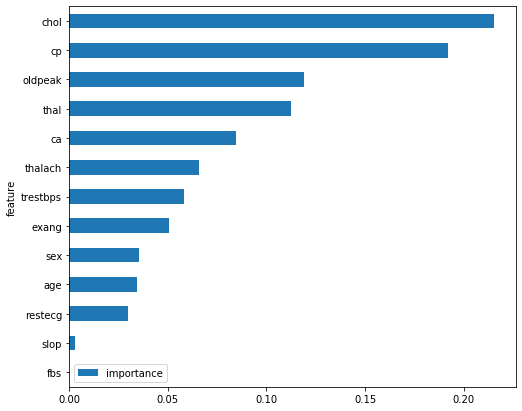

In [24]:
fi = get_fi(adaBoostBestClf, Xdev)
fi.plot('feature', 'importance', 'barh', figsize=(8,7), legend = True)

## Clasificación via XG-Boost

En este caso no realizo un grid search exhaustivo, ya que hay muchas combinaciones de hiperparámetros y el tiempo de búsqueda sea hace inagotable. Utilizo, en cambio, una búsqueda aleatoria de 50.000 iteraciones, que es lo suficientemente grande como para encontrar un conjunto de hiperparámetros óptimos o cuasi-óptimos 

In [25]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Hacemos un randomized search para determinar cuales son los mejores parametros para el XGBoost classifier.
# Los parametros en este caso son:
# n_estimators: el número máximo de estimadores base a utilizar (cantidad de iteraciones)
# learning_rate: tasa de aprendizaje que controla la contribución de cada estimador.  
# subsample: la proporción de muestras a tomar de X para entrenar cada estimador base
# colsample_bytree: la proporción de features (columnas) a tomar de X cada vez que se construye un árbol.
# colsample_bylevel: la proporción de features (respecto de los ya elegidos para cada arbol via colsample_bytree) 
#                    a utilizar en cada nivel del árbol.
# colsample_bynode: la proporción de features (respecto de los ya elegidos para un dado nivel via colsample_bylevel) 
#                    a utilizar en cada nodo cada vez que se evalúa un nuevo split.
# reg_alpha: parámetro de regularización L1 sobre los pesos
# reg_lambda: parámetro de regularización L2 sobre los pesos
parameters = {'learning_rate':np.linspace(.01,.3,59), 'subsample':np.linspace(.5,1,6),
              'colsample_bytree':[4/13, 7/13, 10/13, 1], 'colsample_bylevel':[1/4, 2/4, 3/4, 1],
              'colsample_bynode':[1/4, 2/4, 3/4, 1], 'n_estimators':range(100, 210, 10),
              'reg_alpha':np.linspace(0,1,11), 'reg_lambda':np.linspace(0,1,11)}

# scale_pos_weight: controla el balance de los pesos positivos y negativos. Se suele usar como óptimo el cociente entre 
# numero de instancias negativas y positivas, que en este caso dan 0.8733
clf = XGBClassifier(max_depth = 10, random_state = 0, scale_pos_weight = .8733)

XGBClf = RandomizedSearchCV(clf, parameters, n_iter=50000, n_jobs=-1, cv=5, scoring=scoring, refit='f1')

# DESCOMENTAR PARA CORRER EL RANDOMIZED SEARCH Y MOSTRAR RESULTADOS DE SCORES (TARDA UNA HORA!!!!)
#XGBClf.fit(Xdev, ydev)
#showCVScores(XGBClf)

**RESULTADOS CV - XGBOOST** </br>
<i>Resultado de scores promedios sobre los conjuntos de validación en cada fold:</i>

Accuracy promedio: 85.05% +/- 1.01% </br>
Precision promedio: 85.49% +/- 1.23% </br>
Recall promedio: 87.96% +/- 2.89% </br>
F1 promedio: 86.66% +/- 1.12% </br>
TP Rate promedio: 48.74% </br>
FP Rate promedio: 8.28% </br>
TN Rate promedio: 36.31% </br>
FN Rate promedio: 6.67%

**HIPERPARÁMETROS ÓPTIMOS - XGBOOST:** </br>
- n_estimators = 20
- learning_rate = 0.01
- subsample = 0.75
- colsample_bytree = .8
- colsample_bylevel = .25
- colsample_bynode = .5
- reg_lambda = 0.3333
- scale_pos_weight = 1.18

In [26]:
# MEJOR CLASIFICADOR XG BOOST
XGBBestClf = XGBClassifier(max_depth = 10, random_state = 0, subsample = .75, scale_pos_weight = .8073, 
                           reg_lambda = .6666666666, reg_alpha = 0, n_estimators = 20, learning_rate = 0.01,
                           colsample_bytree = .8, colsample_bynode = .5, colsample_bylevel = .25)

XGBBestClf.fit(Xdev, ydev)
ypred_xgb = XGBBestClf.predict(Xtest)

showTestScores(ytest, ypred_xgb)

Accuracy: 85.87%
Precision: 85.85%
Recall: 89.22%
F1: 87.50%
TP Rate: 49.46%
FP Rate: 8.15%
TN Rate: 36.41%
FN Rate: 5.98%


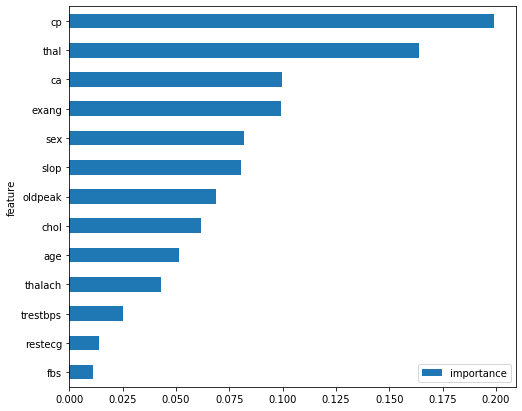

In [27]:
fi = get_fi(XGBBestClf, Xdev)
fi.plot('feature', 'importance', 'barh', figsize=(8,7), legend = True)

In [28]:
# Guardo el modelo con los mejores hiperparametros
#best_estimator = XGBClf.best_estimator_
#best_params = XGBClf.best_params_
#params = best_estimator.get_params()

Construyo y grafico las matrices de confusión para cada ensamble:

In [29]:
from sklearn.metrics import confusion_matrix

cm_bagging = confusion_matrix(ytest,ypred_bagging)
cm_rf = confusion_matrix(ytest,ypred_rf)
cm_adaboost = confusion_matrix(ytest,ypred_adaboost)
cm_xgb = confusion_matrix(ytest,ypred_xgb)

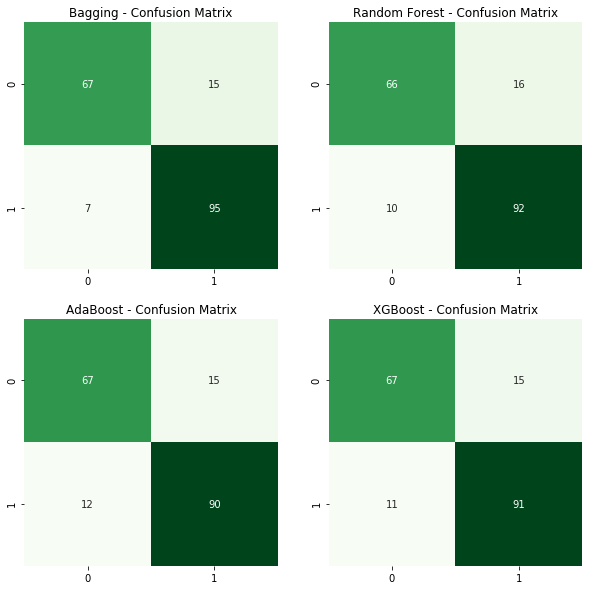

In [30]:
plt.figure(figsize=(10,10))


plt.subplot(2,2,1)
plt.title("Bagging - Confusion Matrix")
sns.heatmap(cm_bagging,annot=True,cmap=plt.cm.Greens,fmt="d",cbar=False)

plt.subplot(2,2,2)
plt.title("Random Forest - Confusion Matrix")
sns.heatmap(cm_rf,annot=True,cmap=plt.cm.Greens,fmt="d",cbar=False)

plt.subplot(2,2,3)
plt.title("AdaBoost - Confusion Matrix")
sns.heatmap(cm_adaboost,annot=True,cmap=plt.cm.Greens,fmt="d",cbar=False)

plt.subplot(2,2,4)
plt.title("XGBoost - Confusion Matrix")
sns.heatmap(cm_xgb,annot=True,cmap=plt.cm.Greens,fmt="d",cbar=False)

plt.show()